# CSO `observations` API Demonstration

2021-1-8. https://github.com/emiliom

Demonstration of the use of the CSO `observations` API. For more documentation see https://github.com/communitysnowobs/cso-api/blob/master/README.md

In [1]:
%matplotlib inline

import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

## Issue request and load results into a GeoDataFrame

Bounding box request parameters will be taken from `CSO_domains.json`

In [2]:
# Load CSO domain JSON
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()

# Domain to be used
domain = 'WY'

In [3]:
# Domain bounding box and projection
Bbox = domains[domain]['Bbox']
stn_proj = domains[domain]['stn_proj']

In [4]:
params = {
  "bbox": f"{Bbox['lonmin']}, {Bbox['latmax']}, {Bbox['lonmax']}, {Bbox['latmin']}",
  "startDate": '2019-9-1',
  "endDate": '2020-3-1',
  "format": "geojson",
  "limit": 5000,
}

csodata_resp = requests.get("https://api.communitysnowobs.org/observations", params=params)
csodatajson = csodata_resp.json()

In [5]:
CSO_gdf = gpd.GeoDataFrame.from_features(csodatajson, crs=stn_proj)
# Convert timestamp from string to datetime type
CSO_gdf['timestamp'] = pd.to_datetime(CSO_gdf.timestamp)
CSO_gdf.sort_values('timestamp', inplace=True)

## Explore the dataset

In [6]:
len(CSO_gdf)

69

In [7]:
CSO_gdf.head()

,geometry,id,author,depth,source,timestamp,elevation
68,POINT (-111.06764 43.69510),WlKPTkn5,Teton Valley,3.00,MountainHub,2019-10-28 15:08:20.818000+00:00,1922.723145
67,POINT (-110.98569 43.70119),n1lfrb1t,Katie O’Connell,30.48,MountainHub,2019-11-16 19:34:07.376000+00:00,2707.184814
66,POINT (-110.94630 43.48830),yxGpBU4N,Allen OBannon,85.00,MountainHub,2019-12-21 20:31:25.887000+00:00,2521.308350
65,POINT (-110.94908 43.48673),iQmktvUg,Allen OBannon,125.00,MountainHub,2019-12-21 21:16:08.240000+00:00,2558.997803
64,POINT (-110.98488 43.49086),ySM25tVp,Allen OBannon,105.00,MountainHub,2019-12-23 19:53:47.163000+00:00,2532.504883


In [8]:
CSO_gdf.tail()

,geometry,id,author,depth,source,timestamp,elevation
4,POINT (-110.18371 43.82351),cKvcogxm,jared spaulding,150.0,MountainHub,2020-02-15 21:15:14.465000+00:00,2910.456299
3,POINT (-110.56087 43.63153),0Lk5ZXTG,Luke LeMaire,74.0,SnowPilot,2020-02-17 22:30:00+00:00,2529.348389
2,POINT (-110.74249 43.70182),wJDc1G8d,Siri Berg-Moberg,150.0,MountainHub,2020-02-18 19:44:19.803000+00:00,2115.754395
1,POINT (-111.02984 43.70405),R9SHDuk1,Katie O’Connell,90.0,MountainHub,2020-02-21 23:05:23.493000+00:00,2172.864746
0,POINT (-110.89353 43.75956),pxp5gyZL,Katie O’Connell,230.0,MountainHub,2020-02-23 21:07:29.868000+00:00,2770.230713


Summarize observations by `source` and `timestamp`:

In [9]:
CSO_gdf[['source', 'timestamp']].groupby(['source']).agg(['count', 'min', 'max'])

timestamp                                   \
                count                              min   
source                                                   
MountainHub        53 2019-10-28 15:08:20.818000+00:00   
SnowPilot          16        2020-02-01 19:36:00+00:00   

                                              
                                         max  
source                                        
MountainHub 2020-02-23 21:07:29.868000+00:00  
SnowPilot          2020-02-17 22:30:00+00:00

Explore "MountainHub" `source` only:

In [10]:
CSO_gdf[CSO_gdf.source == 'MountainHub'].tail()

,geometry,id,author,depth,source,timestamp,elevation
9,POINT (-110.21715 43.20181),xVbxTGH3,James Molloy,145.0,MountainHub,2020-02-10 18:45:25.857000+00:00,2525.746582
4,POINT (-110.18371 43.82351),cKvcogxm,jared spaulding,150.0,MountainHub,2020-02-15 21:15:14.465000+00:00,2910.456299
2,POINT (-110.74249 43.70182),wJDc1G8d,Siri Berg-Moberg,150.0,MountainHub,2020-02-18 19:44:19.803000+00:00,2115.754395
1,POINT (-111.02984 43.70405),R9SHDuk1,Katie O’Connell,90.0,MountainHub,2020-02-21 23:05:23.493000+00:00,2172.864746
0,POINT (-110.89353 43.75956),pxp5gyZL,Katie O’Connell,230.0,MountainHub,2020-02-23 21:07:29.868000+00:00,2770.230713


## Plot the points

Symbolize by source and plot on top of a terrain basemap.

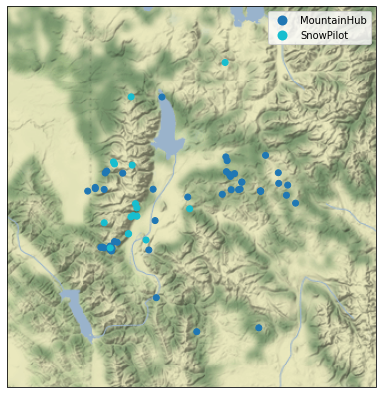

In [11]:
bnd = CSO_gdf.geometry.bounds
stamen_terrain = cimgt.Stamen('terrain-background')
dx, dy = 0.4, 0.2

fig, ax = plt.subplots(
    figsize=(7, 7), subplot_kw={"projection": stamen_terrain.crs}
)
ax.set_extent([bnd.minx.min() - dx, bnd.maxx.max() + dx, bnd.miny.min() - dy, bnd.maxy.max() + dy])

ax.add_image(stamen_terrain, 8)
CSO_gdf.plot(ax=ax, column='source', categorical=True, legend=True, transform=ccrs.PlateCarree());